In [7]:
import os
import pandas as pd
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import numpy as np

Logistic Regression (LR)

Linear Discriminant Analysis (LDA)

K-Nearest Neighbor (KNN)

Decision Tree (CART)

Naïve Bayes (NB)

Support Vector Machine (SVM)

AdaBoost (AB)

Gradient Boosting Machine (GBM)

Random Forest (RF)

Extra Trees (ET)

Multi-Layer Perceptron (MLP)

In [4]:

# ========== Load Data ==========
inner_dir = "./DHFR/"
edge_list = pd.read_csv(os.path.join(inner_dir, 'DHFR_A.txt'), header=None)
node_attributes = pd.read_csv(os.path.join(inner_dir, 'DHFR_node_attributes.txt'), header=None)
node_labels = pd.read_csv(os.path.join(inner_dir, 'DHFR_node_labels.txt'), header=None)
graph_indicator = pd.read_csv(os.path.join(inner_dir, 'DHFR_graph_indicator.txt'), header=None)
graph_labels = pd.read_csv(os.path.join(inner_dir, 'DHFR_graph_labels.txt'), header=None)

edge_list.columns = ['source', 'target']
node_labels.columns = ['node_label']
graph_indicator.columns = ['graph_id']
graph_labels.columns = ['graph_label']

In [5]:
# ========== Prepare Graphs ==========
graph_id_to_nodes = graph_indicator.reset_index().groupby('graph_id')['index'].apply(list).to_dict()

graphs = {}
for graph_id, nodes in graph_id_to_nodes.items():
    node_set = set(nodes)
    edges = edge_list[
        edge_list['source'].isin(node_set) & edge_list['target'].isin(node_set)
    ]
    G = nx.Graph()
    G.add_edges_from(edges.values)
    # Assign node labels (atom types)
    for node in nodes:
        G.add_node(node, atom_label=node_labels.iloc[node, 0])
    graphs[graph_id] = G

## Feature Engineering 

In [6]:
# assume node labels are atomic numbers
# ========== Helper: Graph -> RDKit Molecule ==========
def graph_to_molecule(G):
    mol = Chem.RWMol()
    idx_map = {}  # Mapping from graph node id to mol atom id
    for node, data in G.nodes(data=True):
        atom_label = int(data['atom_label'])
        # Map node label to atomic number
        atomic_number = atom_label  # Assume atom_label is atomic number directly
        atom = Chem.Atom(atomic_number)
        atom_idx = mol.AddAtom(atom)
        idx_map[node] = atom_idx
    for u, v in G.edges():
        try:
            # # no edge attributes only edges -> default all bonds to single bonds
            mol.AddBond(idx_map[u], idx_map[v], Chem.rdchem.BondType.SINGLE)
        except:
            continue
    return mol.GetMol()


In [8]:
# ========== Generate Fingerprints ==========
fingerprints = {}
for graph_id, G in tqdm(graphs.items()):
    mol = graph_to_molecule(G)
    Chem.SanitizeMol(mol, catchErrors=True)  # Fix molecule if needed
    # You can choose either ECFP4 (Morgan) or FP2
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)  # ECFP4
    # fp = Chem.RDKFingerprint(mol)  # Or use FP2 (like RDKFingerprint)
    fingerprints[graph_id] = fp

  0%|          | 0/756 [00:00<?, ?it/s][09:35:52] Explicit valence for atom # 7 H, 3, is greater than permitted
[09:35:52] DEPRECATION WARNING: please use MorganGenerator
[09:35:52] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /Users/runner/work/rdkit-pypi/rdkit-pypi/build/temp.macosx-11.0-arm64-cpython-313/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

  0%|          | 0/756 [00:00<?, ?it/s]


RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2024.09.6
	BOOST: 1_85


In [ ]:
fingerprints = {}
broken_molecules = []

for graph_id, G in tqdm(graphs.items()):
    mol = graph_to_molecule(G)
    try:
        Chem.SanitizeMol(mol)  # remove catchErrors=True to force proper validation
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)  # ECFP4
        fingerprints[graph_id] = fp
    except Exception as e:
        print(f"Graph {graph_id} failed: {e}")
        broken_molecules.append(graph_id)

In [19]:
from rdkit import Chem

# Max allowed bonds (very basic chemical rules)
max_valence = {
    1: 1,  # H
    6: 4,  # C
    7: 3,  # N
    8: 2,  # O
    9: 1,  # F
    16: 2, # S (simple version; could be 4 or 6 too)
    17: 1, # Cl
    35: 1, # Br
    53: 1, # I
}
def fix_valence(mol):
    rw_mol = Chem.RWMol(mol)  # make a writable copy
    
    for atom in rw_mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        allowed_valence = max_valence.get(atomic_num, None)
        if allowed_valence is None:
            continue  # unknown atom

        total_bonds = sum([b.GetBondTypeAsDouble() for b in atom.GetBonds()])
        
        # === FIRST: if too many connections, remove weak bonds ===
        if total_bonds > allowed_valence:
            bonds_to_remove = []
            for bond in atom.GetBonds():
                neighbor = bond.GetOtherAtom(atom)
                if neighbor.GetAtomicNum() == 1:  # Hydrogen
                    bonds_to_remove.append((atom.GetIdx(), neighbor.GetIdx()))
            # remove all bonds to H first
            for a1, a2 in bonds_to_remove:
                rw_mol.RemoveBond(a1, a2)
                total_bonds = sum([b.GetBondTypeAsDouble() for b in rw_mol.GetAtomWithIdx(a1).GetBonds()])
                if total_bonds <= allowed_valence:
                    break

        # === SECOND: still overbonded? remove other bonds ===
        if total_bonds > allowed_valence:
            bonds_to_remove = []
            for bond in atom.GetBonds():
                neighbor = bond.GetOtherAtom(atom)
                bonds_to_remove.append((atom.GetIdx(), neighbor.GetIdx()))
            for a1, a2 in bonds_to_remove:
                rw_mol.RemoveBond(a1, a2)
                total_bonds = sum([b.GetBondTypeAsDouble() for b in rw_mol.GetAtomWithIdx(a1).GetBonds()])
                if total_bonds <= allowed_valence:
                    break

        # === THIRD: if underbonded (rare), you could increase bond orders (not needed now) ===
    
    return rw_mol.GetMol()


In [20]:
fingerprints = {}
broken_molecules = []

for graph_id, G in tqdm(graphs.items()):
    mol = graph_to_molecule(G)
    try:
        mol = fix_valence(mol)
        Chem.SanitizeMol(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fingerprints[graph_id] = fp
    except Exception as e:
        print(f"Graph {graph_id} failed after fix: {e}")
        broken_molecules.append(graph_id)

  0%|          | 0/756 [00:00<?, ?it/s][09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPRECATION WARNING: please use MorganGenerator
[09:49:45] DEPREC

In [21]:
print(f"Graphs total: {len(graphs)}")
print(f"Fingerprints successfully generated: {len(fingerprints)}")
print(f"Graphs that failed: {len(broken_molecules)}")

Graphs total: 756
Fingerprints successfully generated: 756
Graphs that failed: 0


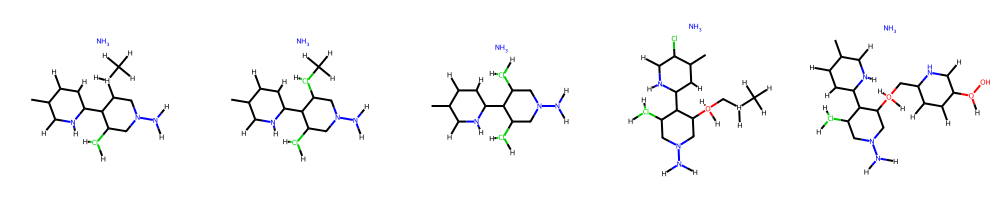

In [23]:
from IPython.display import display
from rdkit.Chem import Draw

# Pick some molecules
mols = [graph_to_molecule(G) for G in list(graphs.values())[:5]]

# Draw them
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))

# Show image
display(img)

In [ ]:
# ========== Save Fingerprints ==========
fp_array = np.array([list(fp.ToBitString()) for fp in fingerprints.values()], dtype=int)
print(fp_array.shape) 